## Problem
Build a Deep Learning classification model that takes the hierarchy into consideration.
Take any 4 categories from the dataset (100 images each) such that there is a hierarchical relationship between them for eg:

Animals
- Dog
- Cat

~~Flowers~~ Fruits
- ~~Rose~~ Grapes
- ~~Sunflower~~ Pear

Build a Classification model for the above 4 categories, such that the penalty of inter-category prediction is higher.

## Import stuff

In [1]:
import os
import numpy as np
import sys
from PIL import Image
import PIL.ImageOps

from textwrap import wrap
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import random

import keras
from keras import layers as L
from keras import optimizers as opt
from keras.preprocessing.image import ImageDataGenerator

# for reproducibility
from numpy.random import seed
seed(41)
from tensorflow import set_random_seed
set_random_seed(41)

Using TensorFlow backend.


## Extract and save the image files (28x28) from .npy files

Do not run next __two__ code cell. Data has already been prepared and kept in folders

### Split the npy file and save images

In [ ]:
# WARNING: this cell needed to run only once. After downloading the npy files

# used code from: https://github.com/C-Aniruddh/RapidDraw/blob/in-dev/processing/process_all.py
number_images = 100; # Number of images in each category
img_width, img_height = 28, 28


npy_dir = '../data_dump/'
out_dir = './data/'
npy_files = [f for f in os.listdir(npy_dir) if os.path.isfile(os.path.join(npy_dir, f))]
print('Available classes:')
print(npy_files)

categories = []

for x in npy_files:
    category_split = x.split('.')
    category = category_split[0]
    categories.append(category)
    
print('Data from following classes will be unpacked:')
print(categories)

for y in categories:
    if not os.path.exists(os.path.join(out_dir, y)):
        os.makedirs(os.path.join(out_dir, y))

index_cat = 0
for z in npy_files:
    print('Processing file', z)
    images = np.load(os.path.join(npy_dir, z))
    print('Saving in', categories[index_cat])
    number_imgs = range(0, number_images, 1)
    for a in number_imgs:
        print('\t Processing Image', a+1)
        file_name = '%s.jpg' % (a+1)
        file_path = os.path.join(out_dir, categories[index_cat], file_name)
        img = images[a].reshape(img_width, img_height)
        f_img = Image.fromarray(img)
        inverted_image = PIL.ImageOps.invert(f_img)
        inverted_image.save(file_path, 'JPEG')
    index_cat = index_cat + 1

### Have a look at few training images

In [ ]:
# randomly picks 4 images per class
r, c = 2, 2
for d in os.listdir(out_dir):
    print(d)
    fig, axs = plt.subplots(r, c)
    cnt = 1
    for i in range(r):
        for j in range(c):
            img = plt.imread(out_dir+d+'/'+str(random.randint(1, 100))+'.jpg')
            axs[i, j].imshow(img, cmap=cm.gray)
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

## Highlevel idea

I chose to use a neural network to build the classifier. The reason is two-fold:
- CNN based neural networks are historically proven to be very strong at image classification, identification tasks.
- The test is on Deep Learning! ;-)

So, My idea is to build a multi-task model. First it will try to classify images into $animal$ or $fruit$ classes and then it will further classify among the four classes ($dog$, $cat$, $grapes$, $pear$).
The reason behind using a multi-task model is 
- I can use different loss weights for different tasks. A higher weight for animal vs fruit classification loss and a comparatively lower weight to 4 class classification loss.
- This particular model construction captures the hierarchical nature of the problem nicely.


### Data description

Pulled out first 100 samples from each class for training and next 100 from each class for validation/testing.
The test data is completely unseen.

## Create and verify the data generator

Why I need a generator when $4*100*(28*28) = 1.2MB$ would fit nicely in computer memory?
- It is good to be prepare a pipeline which can handle large size data
- To show off!

In [2]:
# few constants
data_path = './data/'
val_data_path = './val_data/'
img_width, img_height, n_channel = 28, 28, 3
img_shape = (img_width, img_height)
batch_size = 32

In [3]:
# create a generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_generator = datagen.flow_from_directory(data_path, target_size=(img_width, img_height)
                    , class_mode='categorical'
                    , batch_size=batch_size, interpolation='nearest'
                    , shuffle=True
                   )
val_generator = ImageDataGenerator(
    rescale=1./255).flow_from_directory(val_data_path, target_size=(img_width, img_height)
                    , class_mode='categorical'
                    , batch_size=batch_size, interpolation='nearest'
                    , shuffle=True
                   )

Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


Why do I need the below generator?
- The $train\_generator$ or $val\_generator$ created above produces target for 4 class classification problem. But our $animal vs fruit$ classification needs a different target for the same batch. Please see the inline comments inside the below functions for details about each type of targets.
- Wrapping the generators to produce X_batch, animal vs fruit target and 4 class classification target.

In [4]:
# mode will be train for both training and validation
def combined_generator(datagen, mode='train'):
    y_4c = None
    while True:
        if mode == 'train':
            X_batch, y_4c = datagen.next() # produces 4 class classification target
        else:
            X_batch = datagen.next()
        if y_4c is not None:
            # class and how the target looks for y_4c
            # cat     [1, 0, 0, 0]
            # dog     [0, 1, 0, 0]
            # grapes  [0, 0, 1, 0]
            # pear    [0, 0, 0, 1]

            # for a_vs_f model we need target of shape (batch_size, 2)
            # class cat and dog -> [1, 0]
            # class grapes and pear -> [0, 1]
            # how class and the target should look for a_vs_f model
            # cat     [1, 0]
            # dog     [1, 0]
            # grapes  [0, 1]
            # pear    [0, 1]

            y_a_f = np.zeros((y_4c.shape[0], 2))
            for idx, y in enumerate(y_4c):
                if np.all(y == [1, 0, 0, 0]) or np.all(y == [0, 1, 0, 0]):
                    y_a_f[idx] = [1, 0]
                else:
                    y_a_f[idx] = [0, 1]
            # produce animal vs fruit and 4class classification target for the same set of training images
            yield X_batch, [y_a_f, y_4c]
        else:
            yield X_batch
    

Shape of one batch of data:
X shape:  (32, 28, 28, 3)
y_a_f shape:  (32, 2)
y_4c shape:  (32, 4)


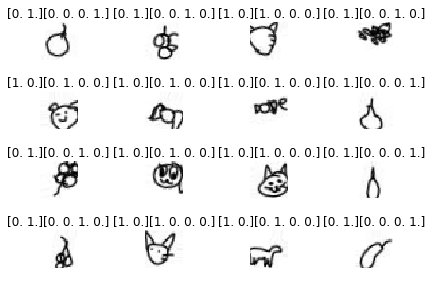

In [5]:
# test how my generator is doing
X, y = next(combined_generator(train_generator)) # ask for a batch

print('Shape of one batch of data:')
print('X shape: ', X.shape)
print('y_a_f shape: ', y[0].shape)
print('y_4c shape: ', y[1].shape)


r, c = 4, 4 # lets not show entire batch, check rxc images
imgs = X[:r*c]
label1 = y[0][:r*c] # animal vs fruit target. see the generator ouput order
label2 = y[1][:r*c] # 4 class classification output. see the generator ouput order

cnt = 0
fig, axs = plt.subplots(r, c)
fig.tight_layout()
for i in range(r):
    for j in range(c):
        img = imgs[cnt]
        axs[i, j].imshow(img, cmap=cm.gray)
        axs[i, j].axis('off')
        axs[i, j].set_title('\n'.join(wrap(str(label1[cnt])+str(label2[cnt]),60))) # took some time to figure this out!
        cnt += 1
plt.show()
plt.close()


## Build models

In [6]:
# some model realted constants
latent_dim = 128
epochs = 50
learning_rate = 1E-4 # with only 100 samples per class, slow cooking (small batch_size, small lr) seems good.

In [7]:
# build the animal vs fruit model
def build_a_vs_f_model(input_dim=(img_width, img_height, n_channel), n_classes=2):
    input_ = L.Input(shape=input_dim)
    x = L.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_)
    x = L.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.25)(x)
    x = L.Flatten()(x)
    feat = L.Dense(latent_dim, activation='relu')(x)
    pred = L.Dense(n_classes, activation='softmax')(feat)

    # this is to classify animal vs fruit
    af_model = keras.models.Model(inputs=input_, outputs=pred, name='af_model')
    # idea is to use this layer output as a input feature to the 4 class classification problem
    af_feature_model = keras.models.Model(inputs=input_, outputs=feat, name='feat_model')
    
    af_model.summary()
    keras.utils.vis_utils.plot_model(af_model, to_file='a_vs_f_model_plot.png', show_shapes=True, show_layer_names=True)

    return af_model, af_feature_model

In [8]:
# build the 4 class classification model
def build_4class_model(input_dim=(img_width, img_height, n_channel), n_classes=4, latent_dim=128):
    input_img = L.Input(shape=input_dim)
    x = L.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_img)
    x = L.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.25)(x)
    x = L.Flatten()(x)
    x = L.Dense(128, activation='relu')(x)
    
    input_feat = L.Input(shape=(latent_dim,))
    y = L.Concatenate()([x, input_feat])
    y = L.Dense(128)(y)
    y = L.Dropout(0.25)(y)
    y = L.Dense(64)(y)
    y = L.Dropout(0.25)(y)
    y = L.Dense(32)(y)
    y = L.Dropout(0.25)(y)
    pred = L.Dense(n_classes, activation='softmax')(y)
    model = keras.models.Model(inputs=[input_img, input_feat], outputs=pred, name='class4_model')
    model.summary()
    keras.utils.vis_utils.plot_model(model, to_file='class4_model_plot.png', show_shapes=True, show_layer_names=True)

    return model

In [9]:
def build_combined_model(a_vs_f_model, feat_model, class4_model):
    inputs = L.Input(shape=(img_width, img_height, n_channel))
    a_f = a_vs_f_model(inputs)
    feat = feat_model(inputs)
    pred = class4_model([inputs, feat])
    model = keras.models.Model(inputs=inputs, outputs=[a_f, pred], name='comb_model')
    model.summary()
    keras.utils.vis_utils.plot_model(model, to_file='comb_model_plot.png', show_shapes=True, show_layer_names=True)
    return model

In [10]:
# now, time to train the model
def train_model():
    
    # create models
    a_vs_f_model, feat_model = build_a_vs_f_model()
    class_4_model = build_4class_model()
    combined_model = build_combined_model(a_vs_f_model, feat_model, class_4_model)
    
    # get opt
    comb_opt = opt.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    loss_weights = [2, 1] # animal vs fruit classification is given more weight
    combined_model.compile(optimizer=comb_opt
                           , loss=['categorical_crossentropy', 'categorical_crossentropy']
                           , loss_weights=loss_weights, metrics=['acc'])
    
    # set up callbacks
    model_filepath = 'model.hdf5'
    chkpoint = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', verbose=1
                    , save_best_only=True, save_weights_only=False, mode='auto', period=1)
    callback_list=[keras.callbacks.History(), chkpoint]
    
    history = combined_model.fit_generator(
            generator=combined_generator(train_generator),
            steps_per_epoch=1+train_generator.n//train_generator.batch_size,
            validation_data=combined_generator(val_generator),
            validation_steps=1+val_generator.n//val_generator.batch_size,
            callbacks=callback_list,
            epochs=epochs
        )
        
    return combined_model, history
    

In [11]:
combined_model, history = train_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)  


Epoch 00002: val_loss improved from 2.77329 to 2.56316, saving model to model.hdf5
Epoch 3/50
13/13 [==============================] - 3s 245ms/step - loss: 2.6532 - af_model_loss: 0.6681 - class4_model_loss: 1.3169 - af_model_acc: 0.6491 - class4_model_acc: 0.3338 - val_loss: 2.3558 - val_af_model_loss: 0.6068 - val_class4_model_loss: 1.1421 - val_af_model_acc: 0.7850 - val_class4_model_acc: 0.6175

Epoch 00003: val_loss improved from 2.56316 to 2.35579, saving model to model.hdf5
Epoch 4/50
13/13 [==============================] - 3s 252ms/step - loss: 2.5570 - af_model_loss: 0.6474 - class4_model_loss: 1.2622 - af_model_acc: 0.6736 - class4_model_acc: 0.4592 - val_loss: 2.2871 - val_af_model_loss: 0.5399 - val_class4_model_loss: 1.2073 - val_af_model_acc: 0.8275 - val_class4_model_acc: 0.4300

Epoch 00004: val_loss improved from 2.35579 to 2.28714, saving model to model.hdf5
Epoch 5/50
13/13 [==============================] - 3s 251ms/step - loss: 2.4373 - af_model_loss: 0.6160 - c


Epoch 00023: val_loss improved from 1.35991 to 1.30742, saving model to model.hdf5
Epoch 24/50
13/13 [==============================] - 4s 286ms/step - loss: 1.7526 - af_model_loss: 0.4500 - class4_model_loss: 0.8526 - af_model_acc: 0.7862 - class4_model_acc: 0.6202 - val_loss: 1.3884 - val_af_model_loss: 0.3317 - val_class4_model_loss: 0.7250 - val_af_model_acc: 0.8775 - val_class4_model_acc: 0.7275

Epoch 00024: val_loss did not improve from 1.30742
Epoch 25/50
13/13 [==============================] - 4s 284ms/step - loss: 1.7363 - af_model_loss: 0.4535 - class4_model_loss: 0.8292 - af_model_acc: 0.7982 - class4_model_acc: 0.6469 - val_loss: 1.2911 - val_af_model_loss: 0.3328 - val_class4_model_loss: 0.6255 - val_af_model_acc: 0.8650 - val_class4_model_acc: 0.7600

Epoch 00025: val_loss improved from 1.30742 to 1.29112, saving model to model.hdf5
Epoch 26/50
13/13 [==============================] - 4s 269ms/step - loss: 1.6881 - af_model_loss: 0.4283 - class4_model_loss: 0.8314 - af

13/13 [==============================] - 4s 281ms/step - loss: 1.4152 - af_model_loss: 0.3624 - class4_model_loss: 0.6903 - af_model_acc: 0.8559 - class4_model_acc: 0.7140 - val_loss: 1.1928 - val_af_model_loss: 0.2718 - val_class4_model_loss: 0.6493 - val_af_model_acc: 0.8975 - val_class4_model_acc: 0.7725

Epoch 00045: val_loss did not improve from 1.15999
Epoch 46/50
13/13 [==============================] - 4s 285ms/step - loss: 1.4363 - af_model_loss: 0.3562 - class4_model_loss: 0.7239 - af_model_acc: 0.8338 - class4_model_acc: 0.7042 - val_loss: 1.2022 - val_af_model_loss: 0.2724 - val_class4_model_loss: 0.6574 - val_af_model_acc: 0.9000 - val_class4_model_acc: 0.7850

Epoch 00046: val_loss did not improve from 1.15999
Epoch 47/50
13/13 [==============================] - 4s 288ms/step - loss: 1.3253 - af_model_loss: 0.3315 - class4_model_loss: 0.6623 - af_model_acc: 0.8824 - class4_model_acc: 0.7355 - val_loss: 1.2541 - val_af_model_loss: 0.2779 - val_class4_model_loss: 0.6982 - v

In [12]:
# lets have a look at the loss and acc of the model for train and val dataset
def plot_model_perf(history):
    # keys are hard to remmeber
    print(history.history.keys())
    
    # summarize history for different accuracies
    plt.plot(history.history['af_model_acc'])
    plt.plot(history.history['val_af_model_acc'])
    plt.title('animal vs fruit model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['class4_model_acc'])
    plt.plot(history.history['val_class4_model_acc'])
    plt.title('4 class model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for losses
    plt.plot(history.history['af_model_loss'])
    plt.plot(history.history['val_af_model_loss'])
    plt.title('animal vs fruit model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['class4_model_loss'])
    plt.plot(history.history['val_class4_model_loss'])
    plt.title('4 class model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'val_af_model_loss', 'val_class4_model_loss', 'val_af_model_acc', 'val_class4_model_acc', 'loss', 'af_model_loss', 'class4_model_loss', 'af_model_acc', 'class4_model_acc'])


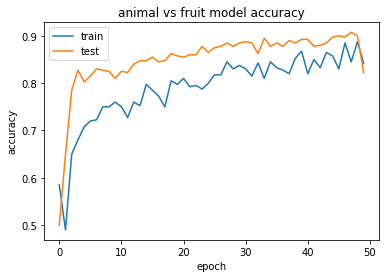

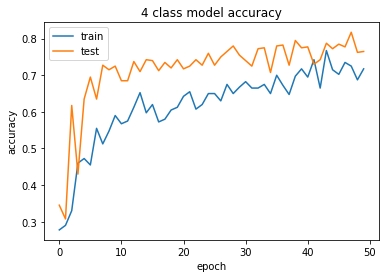

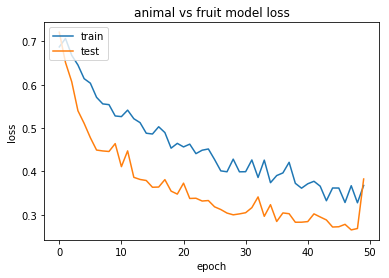

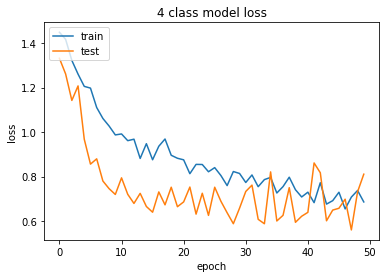

In [13]:
plot_model_perf(history)

## Bonus

### Model architecture

#### animal vs fruit model

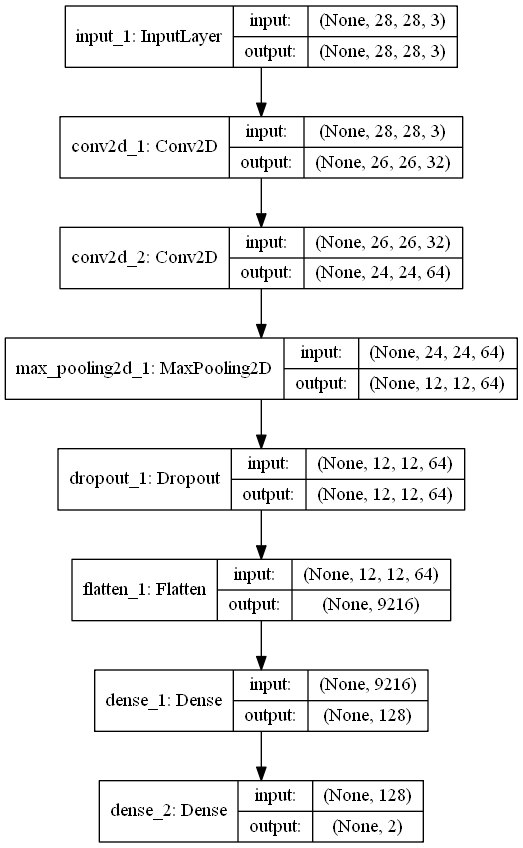

In [14]:
from IPython.display import Image
Image('a_vs_f_model_plot.png')

#### 4 class classification model

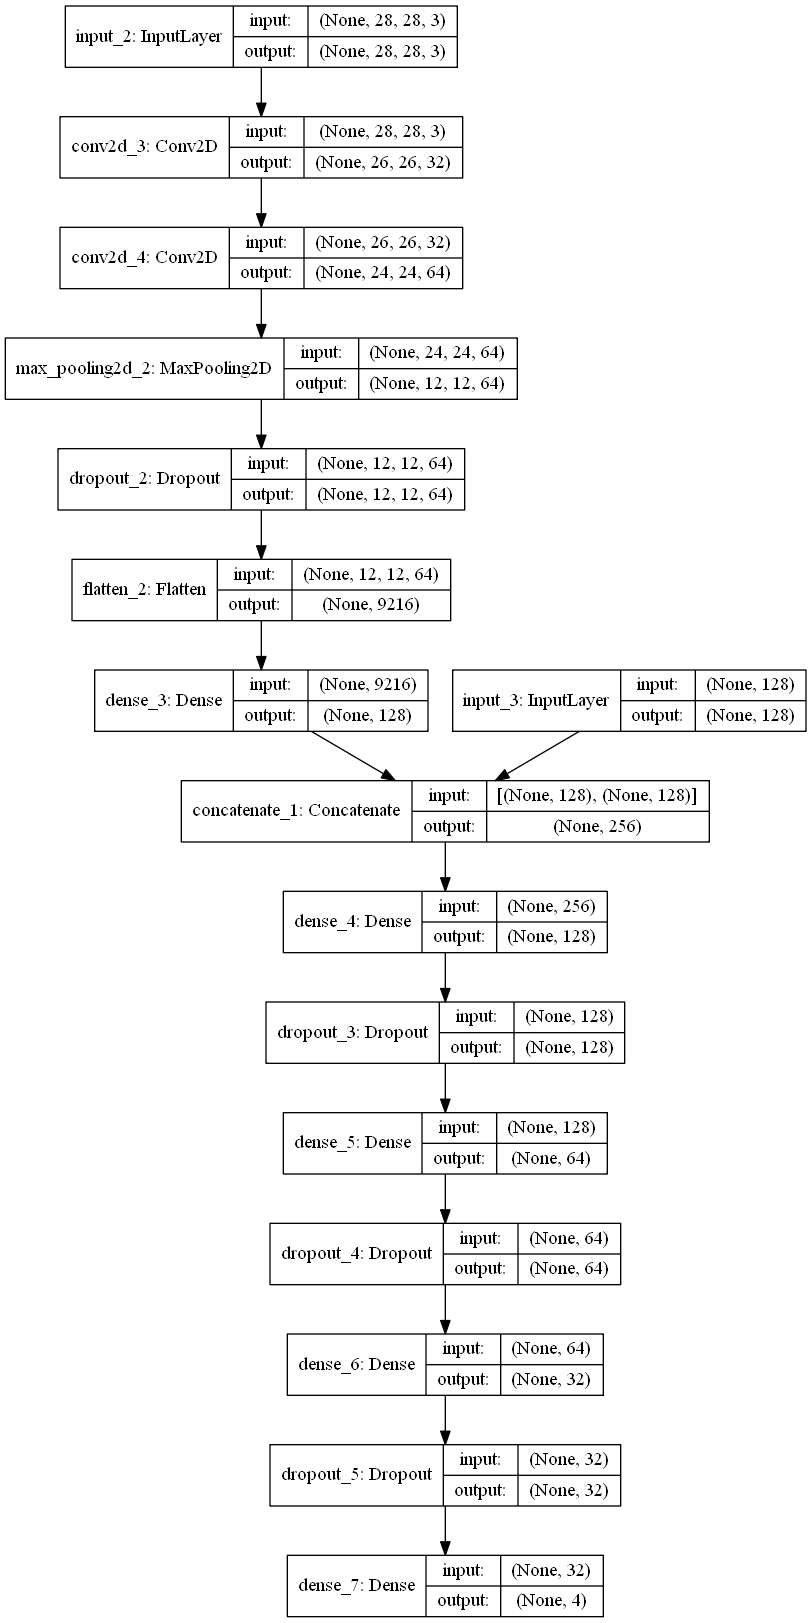

In [15]:
from IPython.display import Image
Image('class4_model_plot.png')

#### Combined model

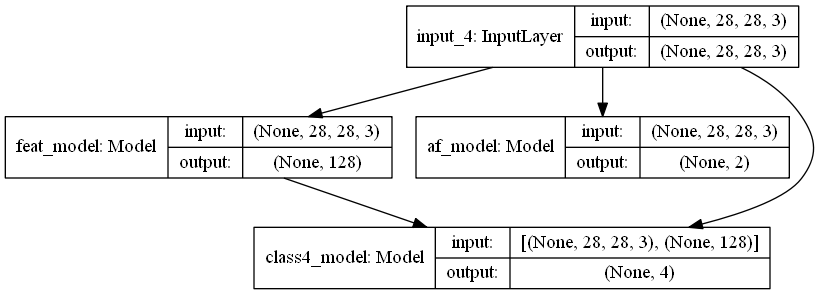

In [16]:
from IPython.display import Image
Image('comb_model_plot.png')

## Next steps

1. Try training animal vs fruit model first, then freeze it and train the comnbined model.
2. Playt with learning rate scheduling. Suppose 1E-4 is my base lr. Linearly increase lr from 1E-6 to 1E-4 over a period of 10 epochs (idea is to not take any catastrophic step while the model wights are still random), then hold the base rate for 30 epochs and finally bring it linearly down to 0 (idea is to take as small steps as possible when the model is stabilised).
3. Add more data.

## The end